<a href="https://colab.research.google.com/github/soumya-569/Hackathons/blob/main/UIDAI_Data_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UIDAI Data Hackathon: Unlocking Societal Trends in Aadhaar Enrolment
---

## Install Required Libraries

In [ ]:
! pip install rapidfuzz

<h2>Import Libraries</h2>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from rapidfuzz import process, fuzz
import re

<h2>Mount Google Drive in Colab</h2>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h2>Reading Data With Pandas</h2>

In [ ]:
path = "/content/drive/MyDrive/My Data/Hackathons/UIDAI Data Hackathon/api_data_aadhar_enrolment/"

enroll_files = []

if os.path.exists(path):
  for filename in os.listdir(path):
    file = os.path.join(path,filename)
    if os.path.isfile(file):
      enroll_files.append(file)

In [ ]:
for index,value in enumerate(enroll_files):
  if index == 0:
    aadhar_enroll1 = pd.read_csv(value)
  elif index == 1:
    aadhar_enroll2 = pd.read_csv(value)
  else:
    aadhar_enroll3 = pd.read_csv(value)

In [ ]:
aadhar_enroll1.head(5)

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,02-03-2025,Meghalaya,East Khasi Hills,793121,11,61,37
1,09-03-2025,Karnataka,Bengaluru Urban,560043,14,33,39
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,09-03-2025,Uttar Pradesh,Aligarh,202133,62,29,15
4,09-03-2025,Karnataka,Bengaluru Urban,560016,14,16,21


### Merge the three tables to get the complete enrollment table dataframe

In [ ]:
aadhar_enroll = pd.concat([aadhar_enroll1,aadhar_enroll2,aadhar_enroll3], ignore_index=True)
aadhar_enroll.head(5)

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,02-03-2025,Meghalaya,East Khasi Hills,793121,11,61,37
1,09-03-2025,Karnataka,Bengaluru Urban,560043,14,33,39
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,09-03-2025,Uttar Pradesh,Aligarh,202133,62,29,15
4,09-03-2025,Karnataka,Bengaluru Urban,560016,14,16,21


In [ ]:
aadhar_enroll.count()

,0
date,1006029
state,1006029
district,1006029
pincode,1006029
age_0_5,1006029
age_5_17,1006029
age_18_greater,1006029


## Implement EDA on Enrollment Dataframe

In [ ]:
aadhar_enroll.describe()

,pincode,age_0_5,age_5_17,age_18_greater
count,1.006029e+06,1.006029e+06,1.006029e+06,1.006029e+06
mean,5.186415e+05,3.525709e+00,1.710074e+00,1.673441e-01
std,2.056360e+05,1.753851e+01,1.436963e+01,3.220525e+00
min,1.000000e+05,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.636410e+05,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.174170e+05,2.000000e+00,0.000000e+00,0.000000e+00
75%,7.001040e+05,3.000000e+00,1.000000e+00,0.000000e+00
max,8.554560e+05,2.688000e+03,1.812000e+03,8.550000e+02


In [ ]:
## Just to test and see the chart because of lot's of outliers

aadhar_enroll_test = aadhar_enroll.loc[aadhar_enroll["age_5_17"] <= np.percentile(aadhar_enroll["age_5_17"],90)]

In [ ]:
## For check the distribution of values

fig = px.histogram(data_frame=aadhar_enroll_test,x="age_5_17",color="state")
fig.update_xaxes(range=[0,30])
fig.show()

The plot labels has inconsistent state name standardization. Multiple entries correspond to the same state but appear under different spellings or formats (e.g., WEST BENGAL, West Bangal), resulting in fragmented labels and misleading distributions.
- We must clean and standardize state names.

After careful observation, we see that the data covers all the 28 state and 8 union-territories.

<Axes: ylabel='age_5_17'>

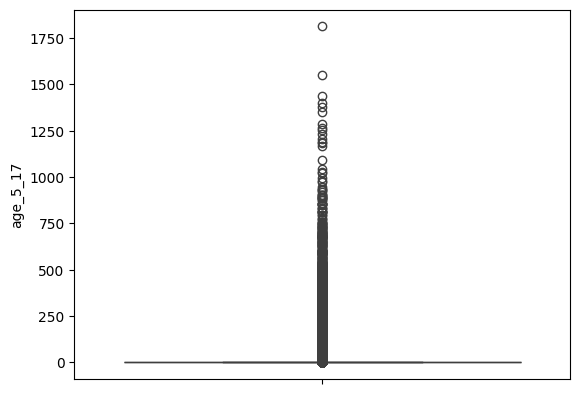

In [ ]:
sns.boxplot(aadhar_enroll["age_5_17"])

## Standardize State names in the dataframe

In [ ]:
# -------------------------------------------------------------------
# Reference List of Valid Indian States and Union Territories
# -------------------------------------------------------------------
# These lists serve as a strict canonical reference for geographic names.
# Fuzzy matching is applied to map inconsistent or misspelled state/UT names in the dataset to the closest valid official name.

valid_states = [
    "Andhra Pradesh",
    "Arunachal Pradesh",
    "Assam",
    "Bihar",
    "Chhattisgarh",
    "Goa",
    "Gujarat",
    "Haryana",
    "Himachal Pradesh",
    "Jharkhand",
    "Karnataka",
    "Kerala",
    "Madhya Pradesh",
    "Maharashtra",
    "Manipur",
    "Meghalaya",
    "Mizoram",
    "Nagaland",
    "Odisha",
    "Punjab",
    "Rajasthan",
    "Sikkim",
    "Tamil Nadu",
    "Telangana",
    "Tripura",
    "Uttar Pradesh",
    "Uttarakhand",
    "West Bengal"
]

union_territories = [
    "Andaman and Nicobar Islands",
    "Chandigarh",
    "Dadra and Nagar Haveli and Daman and Diu",
    "Delhi",
    "Jammu and Kashmir",
    "Ladakh",
    "Lakshadweep",
    "Puducherry"
]

# normailze text before fuzzy matching
def normalize(text):
    text = text.lower().strip()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

# method for applying fuzzy matching and finding the closest valid official name
def standardize_state(state):
    state = normalize(state)
    match, score, _ = process.extractOne(
        state,
        [normalize(s) for s in valid_states],
        scorer=fuzz.token_sort_ratio
    )
    if score > 80:   # threshold
        matched_state =  valid_states[[normalize(s) for s in valid_states].index(match)]
        return {"matched_state":matched_state,"is_union_territory":False}
    else:
      match, score, _ = process.extractOne(
        state,
        [normalize(s) for s in union_territories],
        scorer=fuzz.token_sort_ratio
      )
      if score > 80:   # threshold
        matched_state = union_territories[[normalize(s) for s in union_territories].index(match)]
        return {"matched_state":matched_state,"is_union_territory":True}

      return {"matched_state":"Unknown","is_union_territory": None}


In [ ]:
aadhar_enroll["state"] = (
    aadhar_enroll["state"]
    .apply(standardize_state)
    .apply(lambda x: x["matched_state"])
)

In [ ]:
aadhar_enroll["is_union_territory"] = (
    aadhar_enroll["state"]
    .apply(standardize_state)
    .apply(lambda x: x["is_union_territory"])
)

In [ ]:
aadhar_enroll["state"].unique()

array(['Meghalaya', 'Karnataka', 'Uttar Pradesh', 'Bihar', 'Maharashtra',
       'Haryana', 'Rajasthan', 'Punjab', 'Delhi', 'Madhya Pradesh',
       'West Bengal', 'Assam', 'Uttarakhand', 'Gujarat', 'Andhra Pradesh',
       'Tamil Nadu', 'Chhattisgarh', 'Jharkhand', 'Nagaland', 'Manipur',
       'Telangana', 'Tripura', 'Mizoram', 'Jammu and Kashmir',
       'Chandigarh', 'Sikkim', 'Odisha', 'Kerala',
       'Dadra and Nagar Haveli and Daman and Diu', 'Arunachal Pradesh',
       'Himachal Pradesh', 'Goa', 'Ladakh', 'Andaman and Nicobar Islands',
       'Unknown', 'Puducherry', 'Lakshadweep'], dtype=object)

In [ ]:
aadhar_enroll["is_union_territory"].value_counts()

,count
is_union_territory,
False,980433
True,21133


In [ ]:
aadhar_enroll["state"].value_counts(normalize=True)*100

,proportion
state,
Uttar Pradesh,10.970757
Tamil Nadu,9.199735
Maharashtra,7.672840
West Bengal,7.609522
Karnataka,6.977731
Andhra Pradesh,6.526949
Bihar,6.020403
Rajasthan,5.582245
Madhya Pradesh,4.992401


In [ ]:
aadhar_enroll["state"].isnull().sum()

np.int64(0)

In [ ]:
aadhar_enroll = aadhar_enroll.loc[aadhar_enroll["state"] != "Unknown"]

In [ ]:
aadhar_enroll.loc[aadhar_enroll["state"] == "Unknown"]

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,is_union_territory


## Standardize district names in the dataframe

Observation on District Name Standardization:
Similar to state names, district names in the dataset are not standardized. However, the same strict standardization approach used for states cannot be directly applied to districts due to the large number of entries and the difficulty of maintaining an exhaustive list of official district names. Additionally, some entries in the district column correspond to city names rather than administrative districts.

To address this, we apply a similarity-based grouping approach, where closely matching district names are clustered together and each group is normalized by overriding all entries with the first observed representative name.

In [ ]:
# This function standardizes district names using fuzzy string matching by grouping similar entries based on a similarity threshold.
# Each district name is mapped to the closest existing match, reducing inconsistencies caused by spelling variations
# while preserving distinct districts when similarity is low.
def standardize_strings(strings, threshold=85):
    unique = []
    mapping = {}

    for s in strings:
        if not unique:
            unique.append(s)
            mapping[s] = s
            continue

        match, score, _ = process.extractOne(
            s, unique, scorer=fuzz.token_sort_ratio
        )

        if score >= threshold:
            mapping[s] = match
        else:
            unique.append(s)
            mapping[s] = s

    return mapping


In [ ]:
mapping = standardize_strings(aadhar_enroll['district'])

aadhar_enroll['district'] = aadhar_enroll['district'].map(mapping)
print(mapping)

{'East Khasi Hills': 'East Khasi Hills', 'Bengaluru Urban': 'Bengaluru Urban', 'Kanpur Nagar': 'Kanpur Nagar', 'Aligarh': 'Aligarh', 'Sitamarhi': 'Sitamarhi', 'Bahraich': 'Bahraich', 'Firozabad': 'Firozabad', 'Purbi Champaran': 'Purbi Champaran', 'Maharajganj': 'Maharajganj', 'Aurangabad': 'Aurangabad', 'Ghaziabad': 'Ghaziabad', 'Faridabad': 'Faridabad', 'Madhubani': 'Madhubani', 'Sikar': 'Sikar', 'Bhagalpur': 'Bhagalpur', 'Amritsar': 'Amritsar', 'Gurugram': 'Gurugram', 'Gautam Buddha Nagar': 'Gautam Buddha Nagar', 'West Delhi': 'West Delhi', 'Bhind': 'Bhind', 'Gwalior': 'Gwalior', 'Katni': 'Katni', 'Coochbehar': 'Coochbehar', 'Lucknow': 'Lucknow', 'Dinajpur Uttar': 'Dinajpur Uttar', 'Marigaon': 'Marigaon', 'Kokrajhar': 'Kokrajhar', 'Agra': 'Agra', 'Haridwar': 'Haridwar', 'Nagaon': 'Nagaon', 'Parbhani': 'Parbhani', 'West Khasi Hills': 'West Khasi Hills', 'North West Delhi': 'North West Delhi', 'West Jaintia Hills': 'West Jaintia Hills', 'Unnao': 'Unnao', 'Saharanpur': 'Saharanpur', 'Di

In [ ]:
adh_dist_list = aadhar_enroll["district"].unique().tolist()

In [ ]:
adh_dist = pd.DataFrame(adh_dist_list)

In [ ]:
adh_dist.duplicated().sum()

np.int64(0)

In [ ]:
aadhar_enroll["district"].nunique()

878

## Final Cleaned dataframe - with standardized state and district names

In [ ]:
aadhar_enroll_cleaned = aadhar_enroll.loc[aadhar_enroll["state"] != "Unknown"]

In [ ]:
aadhar_enroll_cleaned["state"].nunique()

36

In [ ]:
aadhar_enroll_cleaned["district"].nunique()

878

## 1. Percentage share of each age group per row

In [ ]:
age_cols = ["age_0_5", "age_5_17", "age_18_greater"]

# Total enrolments per row
aadhar_enroll_cleaned["total_enrolments"] = aadhar_enroll_cleaned[age_cols].sum(axis=1)

# Percentage share per age group
for col in age_cols:
    aadhar_enroll_cleaned[f"{col}_pct"] = (aadhar_enroll_cleaned[col] / aadhar_enroll_cleaned["total_enrolments"]) * 100


In [ ]:
aadhar_enroll_cleaned["dominant_age_group"] = aadhar_enroll_cleaned[age_cols].idxmax(axis=1)

In [ ]:
aadhar_enroll_cleaned.head()

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,is_union_territory,total_enrolments,age_0_5_pct,age_5_17_pct,age_18_greater_pct,dominant_age_group
0,02-03-2025,Meghalaya,East Khasi Hills,793121,11,61,37,False,109,10.091743,55.963303,33.944954,age_5_17
1,09-03-2025,Karnataka,Bengaluru Urban,560043,14,33,39,False,86,16.279070,38.372093,45.348837,age_18_greater
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001,29,82,12,False,123,23.577236,66.666667,9.756098,age_5_17
3,09-03-2025,Uttar Pradesh,Aligarh,202133,62,29,15,False,106,58.490566,27.358491,14.150943,age_0_5
4,09-03-2025,Karnataka,Bengaluru Urban,560016,14,16,21,False,51,27.450980,31.372549,41.176471,age_18_greater


## 2. State-level age dominance

In [ ]:
state_age_agg = (
    aadhar_enroll_cleaned.groupby("state")[age_cols]
      .sum()
      .reset_index()
)

# Convert to percentage
state_age_agg["total"] = state_age_agg[age_cols].sum(axis=1)

for col in age_cols:
    state_age_agg[f"{col}_pct"] = (state_age_agg[col] / state_age_agg["total"]) * 100

# Dominant age group per state
state_age_agg["dominant_age_group"] = state_age_agg[age_cols].idxmax(axis=1)


In [ ]:
state_age_agg

,state,age_0_5,age_5_17,age_18_greater,total,age_0_5_pct,age_5_17_pct,age_18_greater_pct,dominant_age_group
0,Andaman and Nicobar Islands,479,32,0,511,93.737769,6.262231,0.000000,age_0_5
1,Andhra Pradesh,112445,13746,1495,127686,88.063687,10.765472,1.170841,age_0_5
2,Arunachal Pradesh,1957,2236,151,4344,45.050645,51.473297,3.476059,age_5_17
3,Assam,141235,66085,22877,230197,61.353971,28.708020,9.938010,age_0_5
4,Bihar,262875,334802,11908,609585,43.123600,54.922939,1.953460,age_5_17
5,Chandigarh,2476,211,36,2723,90.929122,7.748806,1.322071,age_0_5
6,Chhattisgarh,82453,18769,1997,103219,79.881611,18.183668,1.934721,age_0_5
7,Dadra and Nagar Haveli and Daman and Diu,679,162,48,889,76.377953,18.222722,5.399325,age_0_5
8,Delhi,69183,22296,3050,94529,73.187064,23.586413,3.226523,age_0_5
9,Goa,1916,254,163,2333,82.126018,10.887270,6.986712,age_0_5


## 3. District-level age dominance

In [ ]:
district_age_agg = (
    aadhar_enroll_cleaned.groupby(["state", "district"])[age_cols]
      .sum()
      .reset_index()
)

district_age_agg["total"] = district_age_agg[age_cols].sum(axis=1)

for col in age_cols:
    district_age_agg[f"{col}_pct"] = (district_age_agg[col] / district_age_agg["total"]) * 100

district_age_agg["dominant_age_group"] = district_age_agg[age_cols].idxmax(axis=1)


In [ ]:
district_age_agg.head(100)

,state,district,age_0_5,age_5_17,age_18_greater,total,age_0_5_pct,age_5_17_pct,age_18_greater_pct,dominant_age_group
0,Andaman and Nicobar Islands,Andamans,70,5,0,75,93.333333,6.666667,0.000000,age_0_5
1,Andaman and Nicobar Islands,Nicobar,65,11,0,76,85.526316,14.473684,0.000000,age_0_5
2,Andaman and Nicobar Islands,North And Middle Andaman,128,4,0,132,96.969697,3.030303,0.000000,age_0_5
3,Andaman and Nicobar Islands,South Andaman,216,12,0,228,94.736842,5.263158,0.000000,age_0_5
4,Andhra Pradesh,Adilabad,1137,281,1,1419,80.126850,19.802678,0.070472,age_0_5
...,...,...,...,...,...,...,...,...,...,...
95,Assam,Majuli,347,157,11,515,67.378641,30.485437,2.135922,age_0_5
96,Assam,Marigaon,6735,2928,824,10487,64.222371,27.920282,7.857347,age_0_5
97,Assam,Nagaon,9002,3478,393,12873,69.929309,27.017789,3.052901,age_0_5
98,Assam,Nalbari,2709,977,195,3881,69.801598,25.173924,5.024478,age_0_5


## 4. Does dominance change across states?

In [ ]:
state_dominance_summary = (
    state_age_agg["dominant_age_group"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "age_group", "dominant_age_group": "num_states"})
)


In [ ]:
state_dominance_summary

,num_states,count
0,age_0_5,31
1,age_5_17,5


Out of all analyzed states:

31 states are dominated by age_0_5 enrolments

5 states are dominated by age_5_17 enrolments

No state is dominated by age_18_greater

This strongly suggests that Aadhaar enrolment activity across India is primarily driven by early-life registration (0-5 years). This pattern aligns with:

- Hospital-linked newborn enrolment programs

- Integration with birth registration and maternal-child welfare schemes

The smaller set of states dominated by school-age (5-17) enrolments likely reflects:

- Active school-based Aadhaar update drives

- State-level policies tying Aadhaar to scholarships, exams, or mid-day meal schemes

In [ ]:
# Early Childhood Driven States (age_0_5 dominant)
print(
    "Early Childhood Driven States:",
    state_age_agg.loc[
        state_age_agg["dominant_age_group"] == "age_0_5", "state"
    ].tolist()
)

# School-age Driven States (age_5_17 dominant)
print(
    "School-age Driven States:",
    state_age_agg.loc[
        state_age_agg["dominant_age_group"] == "age_5_17", "state"
    ].tolist()
)


Early Childhood Driven States: ['Andaman and Nicobar Islands', 'Andhra Pradesh', 'Assam', 'Chandigarh', 'Chhattisgarh', 'Dadra and Nagar Haveli and Daman and Diu', 'Delhi', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh', 'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Mizoram', 'Odisha', 'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal']
School-age Driven States: ['Arunachal Pradesh', 'Bihar', 'Manipur', 'Meghalaya', 'Nagaland']


In [ ]:
aadhar_enroll_cleaned["district"].unique()

array(['East Khasi Hills', 'Bengaluru Urban', 'Kanpur Nagar', 'Aligarh',
       'Sitamarhi', 'Bahraich', 'Firozabad', 'Purbi Champaran',
       'Maharajganj', 'Aurangabad', 'Ghaziabad', 'Faridabad', 'Madhubani',
       'Sikar', 'Bhagalpur', 'Amritsar', 'Gurugram',
       'Gautam Buddha Nagar', 'West Delhi', 'Bhind', 'Gwalior', 'Katni',
       'Coochbehar', 'Lucknow', 'Dinajpur Uttar', 'Marigaon', 'Kokrajhar',
       'Agra', 'Haridwar', 'Nagaon', 'Parbhani', 'West Khasi Hills',
       'North West Delhi', 'West Jaintia Hills', 'Unnao', 'Saharanpur',
       'Dibrugarh', 'Udalguri', 'Chirang', 'Kamrup', 'Dhubri', 'Jaunpur',
       'Thane', 'Dhemaji', 'Banas Kantha', 'Tinsukia', 'Spsr Nellore',
       'Barpeta', 'Sonitpur', 'Baksa', 'Ludhiana', 'Patan', 'Kanchipuram',
       'Patna', 'Lakhimpur', 'Bongaigaon', 'Vadodara', 'Nainital',
       'Dehradun', 'Hojai', 'Dohad', 'Morbi', 'Raipur', 'Gorakhpur',
       'Bulandshahr', 'Mathura', 'Pashchim Champaran', 'Bijapur',
       'Deoghar', 'Muzaf

In [ ]:
aadhar_enroll_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1001566 entries, 0 to 1006028
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   date                1001566 non-null  object 
 1   state               1001566 non-null  object 
 2   district            1001566 non-null  object 
 3   pincode             1001566 non-null  int64  
 4   age_0_5             1001566 non-null  int64  
 5   age_5_17            1001566 non-null  int64  
 6   age_18_greater      1001566 non-null  int64  
 7   is_union_territory  1001566 non-null  object 
 8   total_enrolments    1001566 non-null  int64  
 9   age_0_5_pct         1001566 non-null  float64
 10  age_5_17_pct        1001566 non-null  float64
 11  age_18_greater_pct  1001566 non-null  float64
 12  dominant_age_group  1001566 non-null  object 
dtypes: float64(3), int64(5), object(5)
memory usage: 107.0+ MB


## 5. How Does Aadhaar Enrolment change Over Time Across Different Age Groups in India?

In [ ]:
aadhar_enroll_cleaned["date"] = aadhar_enroll_cleaned["date"].astype("datetime64[ns]")

In [ ]:
time_wise_enroll = aadhar_enroll_cleaned.groupby("date",observed=False)[["total_enrolments"]].sum().reset_index().sort_values("date",ascending=True)

In [ ]:
time_wise_enroll_age_0_5 = aadhar_enroll_cleaned.groupby("date",observed=False)[["age_0_5"]].sum().reset_index().sort_values("date",ascending=True)

In [ ]:
time_wise_enroll_age_5_17 = aadhar_enroll_cleaned.groupby("date",observed=False)[["age_5_17"]].sum().reset_index().sort_values("date",ascending=True)

In [ ]:
time_wise_enroll_age_18_greater = aadhar_enroll_cleaned.groupby("date",observed=False)[["age_18_greater"]].sum().reset_index().sort_values("date",ascending=True)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=time_wise_enroll["date"],y=time_wise_enroll["total_enrolments"],mode="lines",name="Total Enrollments"))
fig.add_trace(go.Scatter(x=time_wise_enroll_age_0_5["date"],y=time_wise_enroll_age_0_5["age_0_5"],mode="lines",name="Age_0_5"))
fig.add_trace(go.Scatter(x=time_wise_enroll_age_5_17["date"],y=time_wise_enroll_age_5_17["age_5_17"],mode="lines",name="Age_5_17"))
fig.add_trace(go.Scatter(x=time_wise_enroll_age_18_greater["date"],y=time_wise_enroll_age_18_greater["age_18_greater"],mode="lines",name="Age_18_greater"))
fig.update_layout(title={"text":"Enrollments By Age Groups Over Time"},xaxis_title="Date",yaxis_title="Enrollments Count")
fig.show()

A pronounced spike in enrolment is observed across all age groups in January compared to other months. The 0–5 age group consistently records the highest enrolment, followed by the 5–17 group. These age groups exhibit similar temporal trends. In contrast, enrolment for individuals aged 18 and above drops sharply after January and remains negligible for the rest of the year, staying close to the zero line.

## 6. How Does Total Aadhaar Enrolment Vary Over Time Across States?

---



In [ ]:
time_wise_state_enrollments = aadhar_enroll_cleaned.pivot_table(index="date",columns="state",values="total_enrolments",aggfunc="sum")

In [ ]:
time_wise_state_enrollments.fillna(0,inplace=True)

In [ ]:
# time_wise_state_enrollments.plot(kind="line",figsize=(12,6))
# plt.legend(bbox_to_anchor=(1,1))
# plt.show()

fig = px.line(time_wise_state_enrollments,x=time_wise_state_enrollments.index,y=time_wise_state_enrollments.columns)
fig.update_layout(title={"text":"State Wise Enrollments Over Time"},xaxis_title="Date",yaxis_title="Total Enrollments")
fig.show()

Several states exhibit a substantial spike in total enrolment during January, notably Uttar Pradesh, Madhya Pradesh, Gujarat, Bihar, and Maharashtra. This indicates that the overall January surge observed in the previous plot is largely driven by enrolment activity in these states.

[link text](https://)<h2> 7. How Does Aadhaar Enrolment Percentage Vary Over Time Across States When Normalized by State Population?</h2>
<h3><em><mark> We enriched the data</mark> using external State Wise Population data from UIDAI as on Nov-2025</em></h3>
<h4>Then load and transform it in Power Query in Excel</h4>
<a href="https://uidai.gov.in/images/AadhaarSaturationReport.pdf">UIDAI Source Link</a>

In [ ]:
state_wise_population_25 = pd.read_excel("/content/drive/MyDrive/My Data/Hackathons/State_Wise_Population.xlsx")

In [ ]:
state_wise_population_25.rename(columns={"State":"state"},inplace=True)

In [ ]:
## Joined with state_age_agg dataframe

state_wise_population_joined = state_age_agg.merge(state_wise_population_25,on="state",how="left")

In [ ]:
## Tackled 3 ambiguous values in population feature beacuse of name mismatch of states

def fill_na(row):
    if pd.notna(row["Population"]):
        return row["Population"]

    state = row["state"]

    if "Islands" in state:
        return state_wise_population_25.loc[
            state_wise_population_25["state"].str.contains("Islands"),
            "Population"
        ].iloc[0]

    elif "Dadra" in state:
        return state_wise_population_25.loc[
            state_wise_population_25["state"].str.contains("Dadra"),
            "Population"
        ].iloc[0]

    elif "Jammu" in state:
        return state_wise_population_25.loc[
            state_wise_population_25["state"].str.contains("Jammu"),
            "Population"
        ].iloc[0]

    return None

In [ ]:
## Applied the above function with **apply** method to check row wise

state_wise_population_joined["Population"] = (
    state_wise_population_joined.apply(fill_na, axis=1)
)

In [ ]:
## Replaced "","" with ""

state_wise_population_joined["Population"] = state_wise_population_joined["Population"].str.replace(",","")

In [ ]:
## Changed data type from object to integer

state_wise_population_joined["Population"] = state_wise_population_joined["Population"].astype("int64")

In [ ]:
total_population = state_wise_population_joined["Population"].sum()

In [ ]:
## Created Population_Percentage feature

state_wise_population_joined["Population_Percentage"] = (state_wise_population_joined["Population"]/total_population)*100

In [ ]:
## ## Created Enroll_Percenatge feature with total enrolls / total population for that state

state_wise_population_joined["Enroll_Percenatge"] = (state_wise_population_joined["total"]/state_wise_population_joined["Population"])*100

In [ ]:
## Joined state_wise_population_joined with aadhar_enroll_cleaned

state_combined_enrolled = aadhar_enroll_cleaned.merge(state_wise_population_joined,on="state",how="inner")

In [ ]:
## Created Enroll_Percent_Per_Time feature with total_enrolments / Population in each date

state_combined_enrolled["Enroll_Percent_Per_Time"] = state_combined_enrolled["total_enrolments"]/state_combined_enrolled["Population"]

In [ ]:
## Created a pivot table with date as index, state as columns and Enroll_Percent_Per_Time as values with sum

time_wise_state_enroll_percent = state_combined_enrolled.pivot_table(index="date",columns="state",values="Enroll_Percent_Per_Time",aggfunc="sum")

In [ ]:
## Replaced Null values 0 for clean and continuous chart

time_wise_state_enroll_percent.fillna(0,inplace=True)

In [ ]:
fig = px.line(time_wise_state_enroll_percent,x=time_wise_state_enroll_percent.index,y=time_wise_state_enroll_percent.columns)
fig.update_layout(title={"text":"State Wise Enroll Percent Over Time"},xaxis_title="Date",yaxis_title="Enroll Percent")
fig.show()

At the beginning of January, Meghalaya exhibits an exceptionally sharp spike in enrolment when measured as a percentage of its population—several times higher than any other state. This is followed by Nagaland and Assam, while most other states record fewer than 10 enrolment per 10,000 population (i.e., <0.001).

Although Uttar Pradesh dominates in terms of absolute enrolment numbers due to its large population base, it does not lead when enrolment is normalized by population. This contrast highlights the importance of evaluating both absolute counts and per-capita metrics to avoid misleading interpretations.

Beyond the initial January window (post January 9), enrollment percentages drops and no significant enrolment spikes are observed across states for the remainder of the year, suggesting that enrolment activity is highly time-concentrated and likely driven by short-term administrative or policy interventions rather than sustained demand.